# **png2png** - mix two images / morphing animation between images

#### Used libraries: [Stable Diffusion](https://https://github.com/CompVis/stable-diffusion) / [imaginAIry](https://github.com/brycedrennan/imaginAIry). See their licenses for copyright terms. Following code licensed under AGPLv3.
###### Copyright (c) 2022 Dorofeev Alexandr


In [ ]:
#@title Check GPU
!nvidia-smi -L

In [ ]:
#@title Press run. Wait til instance restart and then press on the next cell
%%capture
!pip install imaginairy>=2.0.3 pillow --upgrade
!pip uninstall -y torchtext 

import os
os.kill(os.getpid(), 9)

In [ ]:
#@title Setup

from contextlib import nullcontext

from imaginairy.api import load_model
from PIL import Image
from PIL.Image import Resampling
from io import BytesIO
import requests

import torch
from torch import autocast

from imaginairy.img_utils import pillow_img_to_model_latent
from imaginairy.utils import get_device
from imaginairy.vendored import k_diffusion as K

from imaginairy.samplers.base import get_sampler
from imaginairy.schema import ImaginePrompt, ImagineResult

from imaginairy import imagine, imagine_image_files, ImaginePrompt, WeightedPrompt, LazyLoadingImage

from einops import rearrange

from pytorch_lightning import seed_everything

import numpy as np

from pathlib import Path

import glob

import os
import subprocess
from IPython.display import HTML, display
from base64 import b64encode

import uuid

from imaginairy.utils import (
    fix_torch_group_norm,
    fix_torch_nn_layer_norm,
    get_device,
    instantiate_from_config,
    platform_appropriate_autocast,
)

from imaginairy.img_log import (
    ImageLoggingContext,
    log_conditioning,
    log_img,
    log_latent,
)

def fromnoise(
    prompts,
    latent_channels=4,
    downsampling_factor=8,
    precision="autocast",
    ddim_eta=0.0,
    img_callback=None,
    half_mode=None,
    initial_noise_tensor = None,
    initial_text_cond = None
):
    model = load_model()

    # only run half-mode on cuda. run it by default
    half_mode = half_mode is None and get_device() == "cuda"
    if half_mode:
        model = model.half()
        # needed when model is in half mode, remove if not using half mode
        # torch.set_default_tensor_type(torch.HalfTensor)
    prompts = [ImaginePrompt(prompts)] if isinstance(prompts, str) else prompts
    prompts = [prompts] if isinstance(prompts, ImaginePrompt) else prompts
    _img_callback = None

    with torch.no_grad(), platform_appropriate_autocast(
        precision
    ), fix_torch_nn_layer_norm(), fix_torch_group_norm():
        for prompt in prompts:
            with ImageLoggingContext(
                prompt=prompt,
                model=model,
                img_callback=img_callback,
            ):
                #seed_everything(prompt.seed)
                model.tile_mode(prompt.tile_mode)

                uc = None
                if prompt.prompt_strength != 1.0:
                    uc = model.get_learned_conditioning(1 * [""])
                    log_conditioning(uc, "neutral conditioning")
                if prompt.conditioning is not None:
                    c = prompt.conditioning
                else:
                    total_weight = sum(wp.weight for wp in prompt.prompts)
                    c = sum(
                        model.get_learned_conditioning(wp.text)
                        * (wp.weight / total_weight)
                        for wp in prompt.prompts
                    )
                log_conditioning(c, "positive conditioning")

                shape = [
                    latent_channels,
                    prompt.height // downsampling_factor,
                    prompt.width // downsampling_factor,
                ]
                
                sampler_type = prompt.sampler_type

                sampler = get_sampler(sampler_type, model)
               
                if initial_text_cond != None:
                  c = initial_text_cond

                samples = sampler.sample(
                        initial_noise_tensor = initial_noise_tensor,
                        num_steps=prompt.steps,
                        conditioning=c,
                        batch_size=1,
                        shape=shape,
                        unconditional_guidance_scale=prompt.prompt_strength,
                        unconditional_conditioning=uc,
                        eta=ddim_eta,
                        img_callback=_img_callback,
                )

                x_samples = model.decode_first_stage(samples)
                x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                for x_sample in x_samples:
                    x_sample = x_sample.to(torch.float32)
                    x_sample = 255.0 * rearrange(
                        x_sample.cpu().numpy(), "c h w -> h w c"
                    )
                    x_sample_8_orig = x_sample.astype(np.uint8)
                    img = Image.fromarray(x_sample_8_orig)

                    yield c, ImagineResult(
                        img=img,
                        prompt=prompt,
                        upscaled_img=None,
                        is_nsfw=False,
                    )

def find_noise_for_image(model, pil_img, prompt, steps=50, cond_scale=1.0, half=True):
    img_latent = pillow_img_to_model_latent(model, pil_img, batch_size=1, half=half)
    return find_noise_for_latent(
        model,
        img_latent,
        prompt,
        steps=steps,
        cond_scale=cond_scale,
    )

def find_noise_for_latent(model, img_latent, prompt, steps=50, cond_scale=1.0):
    x = img_latent

    _autocast = autocast if get_device() in ("cuda", "cpu") else nullcontext
    with torch.no_grad():
      with _autocast(get_device()):
        uncond = model.get_learned_conditioning([""])
        cond = model.get_learned_conditioning([prompt])

    s_in = x.new_ones([x.shape[0]])
    dnw = K.external.CompVisDenoiser(model)
    sigmas = dnw.get_sigmas(steps).flip(0)

    with torch.no_grad():
      with _autocast(get_device()):
        for i in range(1, len(sigmas)):
            x_in = torch.cat([x] * 2)
            sigma_in = torch.cat([sigmas[i] * s_in] * 2)
            cond_in = torch.cat([uncond, cond])

            c_out, c_in = [
                K.utils.append_dims(k, x_in.ndim) for k in dnw.get_scalings(sigma_in)
            ]
            t = dnw.sigma_to_t(sigma_in)

            eps = model.apply_model(x_in * c_in, t, cond=cond_in)
            denoised_uncond, denoised_cond = (x_in + eps * c_out).chunk(2)

            denoised = denoised_uncond + (denoised_cond - denoised_uncond) * cond_scale

            d = (x - denoised) / sigmas[i]
            dt = sigmas[i] - sigmas[i - 1]

            x = x + d * dt

            del (
                x_in,
                sigma_in,
                cond_in,
                c_out,
                c_in,
                t,
            )
            del eps, denoised_uncond, denoised_cond, denoised, d, dt

        return (x / x.std())

def prepare_images(frames_path, links, prompts, autogenerate_prompts = False):

  def crop_image(image):
    width, height = image.size
    if width == height:
        return image
    offset  = int(abs(height-width)/2)
    if width>height:
        image = image.crop([offset,0,width-offset,height])
    else:
        image = image.crop([0,offset,width,height-offset])
    return image

  def get_image(link):
    r = requests.get(link, headers={'User-agent': 'Mozilla/5.0'})
    img = Image.open(BytesIO(r.content)).convert('RGB')
    return crop_image(img).resize((512, 512), Resampling.LANCZOS)

  if os.path.isdir(frames_path) and not len(os.listdir(frames_path)) == 0:
    return "Directory is not empty!"
  else:
    os.makedirs(frames_path)
  
  if not links:
    return "Provide images to morph"
  
  images = [get_image(link) for link in links]

  if autogenerate_prompts:
    prompts = [interrogate(image, models=['ViT-L/14']) for image in images]
  elif not prompts:
    return "Provide prompts"

  for img in images:
    thumb = img.copy()
    thumb.thumbnail([256, 256])
    display(thumb)
  return images

def finetune_noises(model, images, prompts, noise_restore_steps = 300, noise_restore_prompt_strength = 0.1):
   return [find_noise_for_image(model, img, prompts[i], noise_restore_steps, noise_restore_prompt_strength, True) for i, img in enumerate(images)]

def showcase_noises(noises, prompts, steps = 50, prompt_strength = 1.6):
 text_conds = []
 for i, noise in enumerate(noises):
  for c, f in fromnoise([ImaginePrompt(prompt = prompts[i], sampler_type="k_euler", steps=steps, prompt_strength=prompt_strength)], initial_noise_tensor = noise):
    thumb = f.img.copy()
    thumb.thumbnail([256, 256])
    display(thumb)
    text_conds.append(c)
 return text_conds

def slerp(t, v0, v1, DOT_THRESHOLD=0.9995):
    """helper function to spherically interpolate two arrays v1 v2"""

    if not isinstance(v0, np.ndarray):
        inputs_are_torch = True
        input_device = v0.device
        v0 = v0.cpu().numpy()
        v1 = v1.cpu().numpy()

    dot = np.sum(v0 * v1 / (np.linalg.norm(v0) * np.linalg.norm(v1)))
    if np.abs(dot) > DOT_THRESHOLD:
        v2 = (1 - t) * v0 + t * v1
    else:
        theta_0 = np.arccos(dot)
        sin_theta_0 = np.sin(theta_0)
        theta_t = theta_0 * t
        sin_theta_t = np.sin(theta_t)
        s0 = np.sin(theta_0 - theta_t) / sin_theta_0
        s1 = sin_theta_t / sin_theta_0
        v2 = s0 * v0 + s1 * v1

    if inputs_are_torch:
        v2 = torch.from_numpy(v2).to(input_device)

    return v2

def make_video_ffmpeg(frame_dir, output_file_name='output.mp4', frame_filename="frame%06d.jpg", fps=30):
    frame_ref_path = str(frame_dir / frame_filename)
    video_path = str(frame_dir / output_file_name)
    subprocess.call(
        f"ffmpeg -r {fps} -i {frame_ref_path} -vcodec libx264 -crf 10 -pix_fmt yuv420p"
        f" {video_path}".split()
    )
    return video_path

def morph(prompts, initial_text_conds, start, end, num_steps = 10, prompt_strength=1.6, frame_filename_ext = '.jpg', frames_path = '/content/frames/', use_lerp = True):

  output_path = Path(frames_path)

  for i, t in enumerate(np.linspace(0, 1, num_steps)):
    current = slerp(float(t), start, end)
    if use_lerp:
     cond = torch.lerp(initial_text_conds[0], initial_text_conds[1], float(t))
    else:
     cond = slerp(float(t), initial_text_conds[0], initial_text_conds[1])
    for c, f in fromnoise([ImaginePrompt(sampler_type="k_euler", steps=50, prompt_strength= prompt_strength)], initial_noise_tensor = current, initial_text_cond = cond):
     f.save(output_path / (f"frame%06d{frame_filename_ext}" % i))
  return make_video_ffmpeg(output_path)

def visualize_video_colab(video_path):
    mp4 = open(video_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

model = load_model().half()

#### Experiment with config parametrs to get near exact input. Have fun!

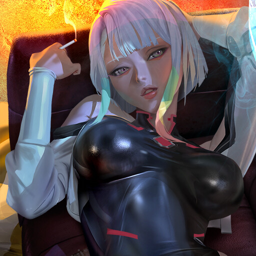

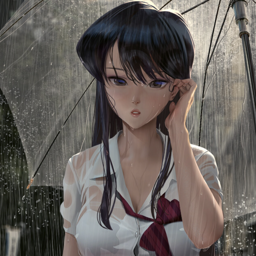

In [ ]:
#@title Input data (if you have no idea about prompt - use CLIP Interrogator)
start_image_link = 'https://i.imgur.com/EGf42rQ.jpg ' #@param {type:"string"}
end_image_link = 'https://i.imgur.com/E335tap.png' #@param {type:"string"}
links = [start_image_link, end_image_link]

autogenerate_prompts = False

start_image_prompt = 'a woman in the latex with white hair sitting in a chair with a cigarette in her hand, cyberpunk art, artstation hd, anime aesthetic' #@param {type:"string"}
end_image_prompt = 'a woman in the white shirt with umbrella behind, a detailed painting, photorealism, artstation hd, anime, detailed painting, anime aesthetic' #@param {type:"string"}
prompts = [start_image_prompt, end_image_prompt]

frames_path = '/content/png2png/' + str(uuid.uuid4())

images = prepare_images(frames_path, links, prompts, autogenerate_prompts)

In [ ]:
#@title Restore noise

noises = None
noise_restore_steps = 100 #@param {type:"integer"}
noise_restore_prompt_strength = 1 #@param {type:"slider", min:-1, max:1, step:0.1}

noises = finetune_noises(model, images, prompts, noise_restore_steps, noise_restore_prompt_strength)

  0%|          | 0/50 [00:00<?, ?it/s]

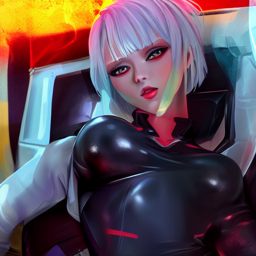

  0%|          | 0/50 [00:00<?, ?it/s]

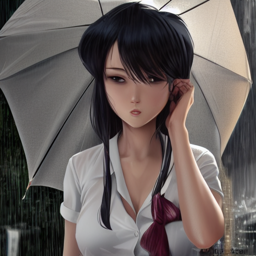

In [ ]:
#@title Finetune restoration

steps = 50 #@param {type:"integer"}

prompt_strength = 1.6 #@param {type:"slider", min:0, max:30, step:0.1}

initial_text_conds = showcase_noises(noises, prompts, steps, prompt_strength)

In [ ]:
#@title Generate video
%%capture
length = 10 #@param {type:"integer"}
use_lerp = False # #@param {type:"boolean"}
video_path = morph(prompts, initial_text_conds, noises[0], noises[1], length, prompt_strength = prompt_strength, frames_path = frames_path, use_lerp = use_lerp)

In [ ]:
#@title Show video
visualize_video_colab(video_path)